In [1]:
import time
import os
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device} / PyTorch version: {torch.__version__}")

using device: cuda / PyTorch version: 2.2.2


In [3]:
def load_hotdog(train_path, test_path, val_split=0.2, batch_size=32):

    train_transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    full_train_dataset = datasets.ImageFolder(
        root=train_path, transform=train_transform
    )
    
    test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

    train_size = int((1 - val_split) * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size]
    )

    val_dataset.dataset = datasets.ImageFolder(
        root=train_path, transform=test_transform
    )
    val_indices = val_dataset.indices
    val_dataset = torch.utils.data.Subset(val_dataset.dataset, val_indices)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    return train_loader, val_loader, test_loader, len(full_train_dataset.classes)


TRAIN_PATH = "data/hotdog/train"
TEST_PATH = "data/hotdog/test"
BATCH_SIZE = 32
VAL_SPLIT = 0.2
train_loader, val_loader, test_loader, num_classes = load_hotdog(
    TRAIN_PATH, TEST_PATH, VAL_SPLIT, BATCH_SIZE
)

In [4]:
def create_model(num_classes, pretrained=True):
    weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
    model = models.resnet50(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
def early_stopping_check(
    val_loss, best_loss, patience_counter, patience, model, save_path, delta=0.001
):
    improved = False

    if val_loss < best_loss - delta:
        best_loss = val_loss
        patience_counter = 0
        improved = True
        torch.save(model.state_dict(), save_path) # 모델 세이브 원래 이렇게 안한다고
        print(f"model saved - val loss: {val_loss:.6f}")
    else:
        patience_counter += 1
        print(f"early stop counter: {patience_counter}/{patience}")

    early_stop = patience_counter >= patience

    return best_loss, patience_counter, early_stop, improved

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 100 == 0:
            print(
                f"batch [{batch_idx}/{len(train_loader)}] - "
                f"loss: {loss.item():.4f}, "
                f"acc: {100.*correct/total:.2f}%"
            )

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

In [7]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=100,
    lr=0.001,
    patience=10,
    save_path="model/best_model.pth",
    scheduler_type="plateau"
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # AdamW로 수정해서 진행해봐도 좋아요!

    if scheduler_type == "plateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-6 # 최소 lr: 1의 -6승 / e == exponential / e뒤에는 지수부 -3.14e+6 ... +는 생략 가능 / 정수부e지수부
        )
    elif scheduler_type == "cosine":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=1e-6
        )
    else:
        raise ValueError("scheduler_type must be 'plateau' or 'cosine'")

    best_val_loss = float("inf")
    patience_counter = 0

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print(f"train start - total {epochs} epochs (scheduler: {scheduler_type})")
    print("=" * 50)

    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nepoch {epoch+1}/{epochs}")
        print("-" * 30)

        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"\nepoch {epoch+1} result:")
        print(f"  train - loss: {train_loss:.4f}, acc: {train_acc:.2f}%")
        print(f"  val - loss: {val_loss:.4f}, acc: {val_acc:.2f}%")
        print(f"  current learning rate: {optimizer.param_groups[0]['lr']:.2e}")

        if scheduler_type == "plateau":
            scheduler.step(val_loss)
        elif scheduler_type == "cosine":
            scheduler.step()

        best_val_loss, patience_counter, early_stop, improved = early_stopping_check(
            val_loss, best_val_loss, patience_counter, patience, model, save_path
        )

        if early_stop:
            print(f"\nearly stop! epoch {epoch+1} - train stop")
            break

    end_time = time.time()
    training_time = (end_time - start_time) / 60
    print(f"\ntrain complete! total time: {training_time:.2f} minutes")

    return train_losses, train_accs, val_losses, val_accs

In [8]:
def evaluate_model(model, test_loader, device, model_path=None, dataset_name="test"):
    if model_path and os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"loaded saved model: {model_path}")

    model.eval()
    correct = 0
    total = 0
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            total += target.size(0)
            correct += (predicted == target).sum().item()

            for i in range(target.size(0)):
                label = target[i].item()
                pred = predicted[i].item()

                if label not in class_total:
                    class_total[label] = 0
                    class_correct[label] = 0

                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

    overall_acc = 100.0 * correct / total

    print(f"\n=== {dataset_name} dataset evaluation result ===")
    print(f"overall accuracy: {overall_acc:.2f}% ({correct}/{total})")

    print(f"\nclass-wise accuracy:")
    for class_idx in sorted(class_total.keys()):
        if class_total[class_idx] > 0:
            acc = 100.0 * class_correct[class_idx] / class_total[class_idx]
            print(
                f"  class {class_idx}: {acc:.2f}% ({class_correct[class_idx]}/{class_total[class_idx]})"
            )

    return overall_acc

In [9]:
def final_evaluation(model, val_loader, test_loader, device, model_path):

    print("\n" + "=" * 60)
    print("final model evaluation")
    print("=" * 60)

    val_acc = evaluate_model(model, val_loader, device, model_path, "val")
    test_acc = evaluate_model(model, test_loader, device, model_path, "test")

    return val_acc, test_acc

In [10]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs, title_suffix=""):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, "b-", label="train loss")
    plt.plot(epochs, val_losses, "r-", label="val loss")
    plt.title(f"model loss {title_suffix}")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, "b-", label="train acc")
    plt.plot(epochs, val_accs, "r-", label="val acc")
    plt.title(f"model acc {title_suffix}")
    plt.xlabel("epoch")
    plt.ylabel("acc (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [11]:
def compare_schedulers():
    EPOCHS = 10
    LEARNING_RATE = 0.001
    PATIENCE = 10
    results = {}
    
    print("\n" + "="*80)
    print("1. ReduceLROnPlateau 스케줄러 실험")
    print("="*80)
    
    model_plateau = create_model(num_classes, pretrained=True).to(device)
    MODEL_SAVE_PATH_PLATEAU = "data/hotdog/best_model_plateau.pth"
    
    train_losses_plateau, train_accs_plateau, val_losses_plateau, val_accs_plateau = train_model(
        model_plateau,
        train_loader,
        val_loader,
        device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        patience=PATIENCE,
        save_path=MODEL_SAVE_PATH_PLATEAU,
        scheduler_type="plateau"
    )
    
    val_acc_plateau, test_acc_plateau = final_evaluation(
        model_plateau, val_loader, test_loader, device, MODEL_SAVE_PATH_PLATEAU
    )
    
    plot_training_history(train_losses_plateau, train_accs_plateau, 
                         val_losses_plateau, val_accs_plateau, "(ReduceLROnPlateau)")
    
    results['plateau'] = {
        'val_acc': val_acc_plateau,
        'test_acc': test_acc_plateau,
        'train_losses': train_losses_plateau,
        'train_accs': train_accs_plateau,
        'val_losses': val_losses_plateau,
        'val_accs': val_accs_plateau
    }
    
    print("\n" + "="*80)
    print("2. CosineAnnealingLR 스케줄러 실험")
    print("="*80)
    
    model_cosine = create_model(num_classes, pretrained=True).to(device)
    MODEL_SAVE_PATH_COSINE = "data/hotdog/best_model_cosine.pth"
    
    train_losses_cosine, train_accs_cosine, val_losses_cosine, val_accs_cosine = train_model(
        model_cosine,
        train_loader,
        val_loader,
        device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        patience=PATIENCE,
        save_path=MODEL_SAVE_PATH_COSINE,
        scheduler_type="cosine"
    )
    
    val_acc_cosine, test_acc_cosine = final_evaluation(
        model_cosine, val_loader, test_loader, device, MODEL_SAVE_PATH_COSINE
    )
    
    plot_training_history(train_losses_cosine, train_accs_cosine, 
                         val_losses_cosine, val_accs_cosine, "(CosineAnnealingLR)")
    
    results['cosine'] = {
        'val_acc': val_acc_cosine,
        'test_acc': test_acc_cosine,
        'train_losses': train_losses_cosine,
        'train_accs': train_accs_cosine,
        'val_losses': val_losses_cosine,
        'val_accs': val_accs_cosine
    }
    
    print("\n" + "="*80)
    print("스케줄러 성능 비교 결과")
    print("="*80)
    print(f"ReduceLROnPlateau - Val Acc: {val_acc_plateau:.2f}%, Test Acc: {test_acc_plateau:.2f}%")
    print(f"CosineAnnealingLR  - Val Acc: {val_acc_cosine:.2f}%, Test Acc: {test_acc_cosine:.2f}%")
    
    plt.figure(figsize=(15, 5))
    epochs_plateau = range(1, len(train_losses_plateau) + 1)
    epochs_cosine = range(1, len(train_losses_cosine) + 1)
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs_plateau, train_losses_plateau, "b-", label="Plateau Train")
    plt.plot(epochs_plateau, val_losses_plateau, "b--", label="Plateau Val")
    plt.plot(epochs_cosine, train_losses_cosine, "r-", label="Cosine Train")
    plt.plot(epochs_cosine, val_losses_cosine, "r--", label="Cosine Val")
    plt.title("Loss 비교")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs_plateau, train_accs_plateau, "b-", label="Plateau Train")
    plt.plot(epochs_plateau, val_accs_plateau, "b--", label="Plateau Val")
    plt.plot(epochs_cosine, train_accs_cosine, "r-", label="Cosine Train")
    plt.plot(epochs_cosine, val_accs_cosine, "r--", label="Cosine Val")
    plt.title("Accuracy 비교")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    schedulers = ['ReduceLROnPlateau', 'CosineAnnealingLR']
    val_accs = [val_acc_plateau, val_acc_cosine]
    test_accs = [test_acc_plateau, test_acc_cosine]
    
    x = range(len(schedulers))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], val_accs, width, label='Val Acc', alpha=0.8)
    plt.bar([i + width/2 for i in x], test_accs, width, label='Test Acc', alpha=0.8)
    
    plt.title("최종 성능 비교")
    plt.xlabel("Scheduler")
    plt.ylabel("Accuracy (%)")
    plt.xticks(x, schedulers)
    plt.legend()
    plt.grid(True, axis='y')
    
    for i, (val_acc, test_acc) in enumerate(zip(val_accs, test_accs)):
        plt.text(i - width/2, val_acc + 0.5, f'{val_acc:.1f}%', ha='center', va='bottom')
        plt.text(i + width/2, test_acc + 0.5, f'{test_acc:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return results


1. ReduceLROnPlateau 스케줄러 실험
train start - total 10 epochs (scheduler: plateau)

epoch 1/10
------------------------------
batch [0/13] - loss: 0.6998, acc: 53.12%

epoch 1 result:
  train - loss: 0.4390, acc: 80.15%
  val - loss: 1.5808, acc: 85.00%
  current learning rate: 1.00e-03
model saved - val loss: 1.580848

epoch 2/10
------------------------------
batch [0/13] - loss: 0.3656, acc: 90.62%

epoch 2 result:
  train - loss: 0.3847, acc: 85.93%
  val - loss: 14.9655, acc: 52.00%
  current learning rate: 1.00e-03
early stop counter: 1/10

epoch 3/10
------------------------------
batch [0/13] - loss: 0.3874, acc: 90.62%

epoch 3 result:
  train - loss: 0.3932, acc: 87.44%
  val - loss: 16.2785, acc: 70.00%
  current learning rate: 1.00e-03
early stop counter: 2/10

epoch 4/10
------------------------------
batch [0/13] - loss: 0.6899, acc: 78.12%

epoch 4 result:
  train - loss: 0.4108, acc: 84.67%
  val - loss: 0.3318, acc: 83.00%
  current learning rate: 1.00e-03
model saved - 

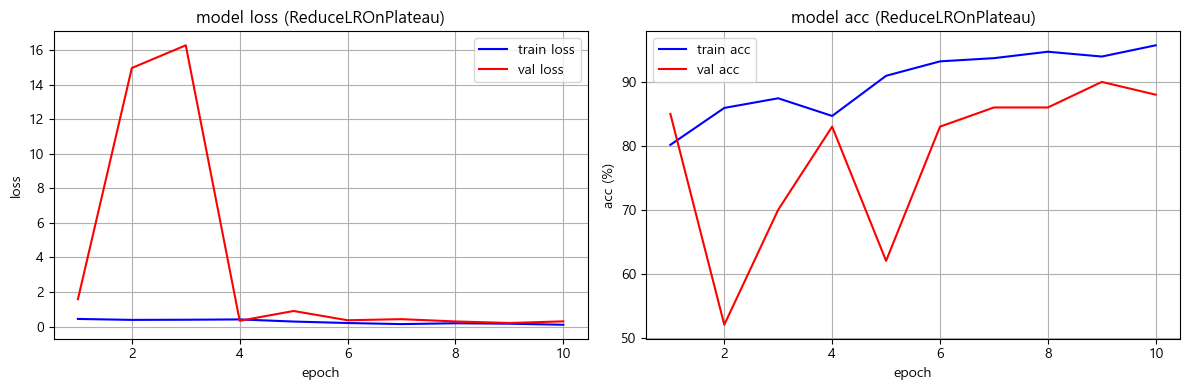


2. CosineAnnealingLR 스케줄러 실험
train start - total 10 epochs (scheduler: cosine)

epoch 1/10
------------------------------
batch [0/13] - loss: 0.6652, acc: 59.38%

epoch 1 result:
  train - loss: 0.4640, acc: 80.40%
  val - loss: 17.3744, acc: 42.00%
  current learning rate: 1.00e-03
model saved - val loss: 17.374377

epoch 2/10
------------------------------
batch [0/13] - loss: 0.2022, acc: 90.62%

epoch 2 result:
  train - loss: 0.3569, acc: 84.17%
  val - loss: 7.0584, acc: 53.00%
  current learning rate: 9.76e-04
model saved - val loss: 7.058414

epoch 3/10
------------------------------
batch [0/13] - loss: 0.3634, acc: 81.25%

epoch 3 result:
  train - loss: 0.3870, acc: 85.18%
  val - loss: 12.5173, acc: 51.00%
  current learning rate: 9.05e-04
early stop counter: 1/10

epoch 4/10
------------------------------
batch [0/13] - loss: 0.3101, acc: 84.38%

epoch 4 result:
  train - loss: 0.3187, acc: 89.20%
  val - loss: 1.2846, acc: 71.00%
  current learning rate: 7.94e-04
model 

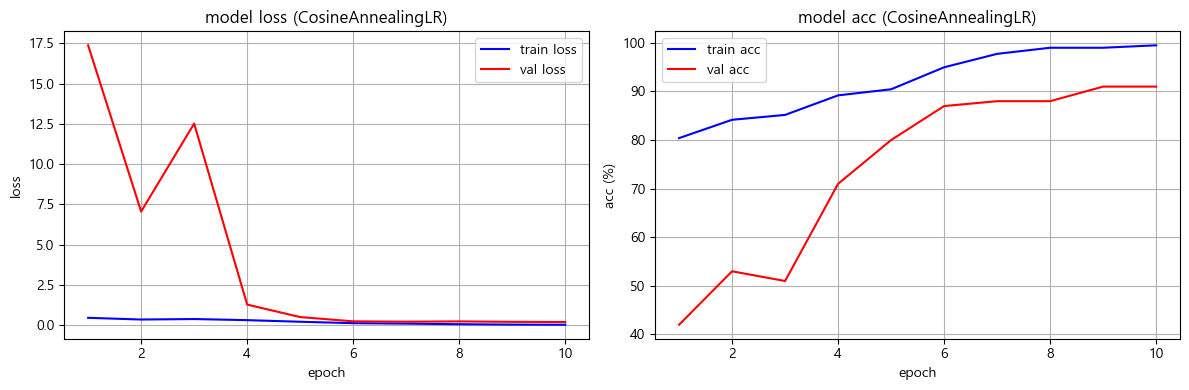


스케줄러 성능 비교 결과
ReduceLROnPlateau - Val Acc: 90.00%, Test Acc: 79.80%
CosineAnnealingLR  - Val Acc: 91.00%, Test Acc: 86.00%


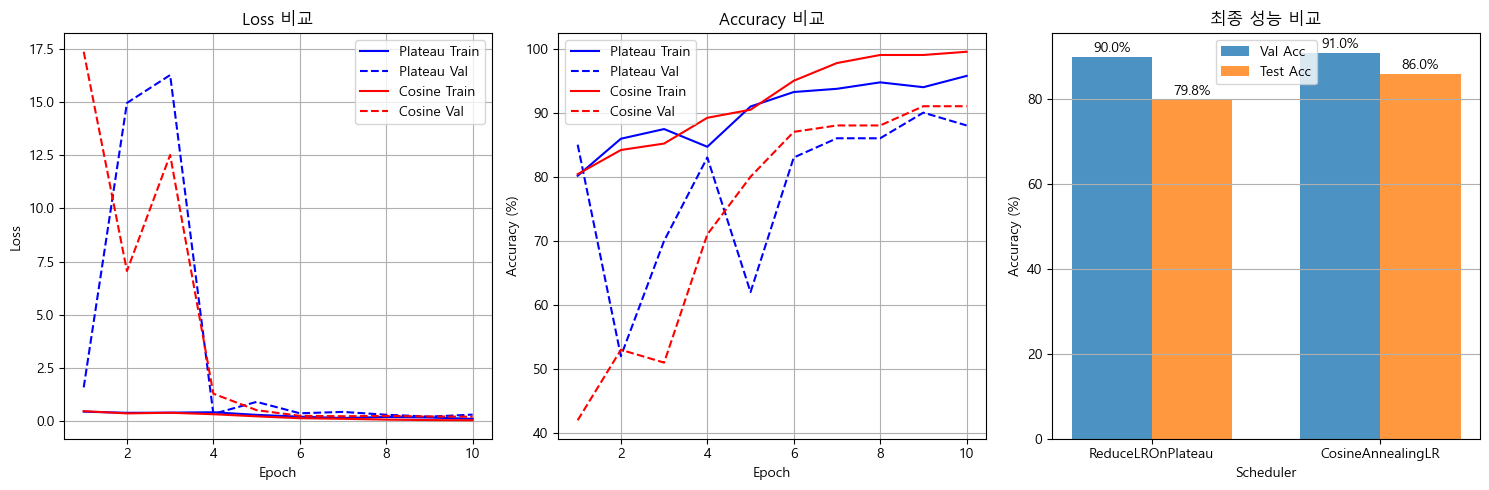

In [12]:
results = compare_schedulers()